In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product

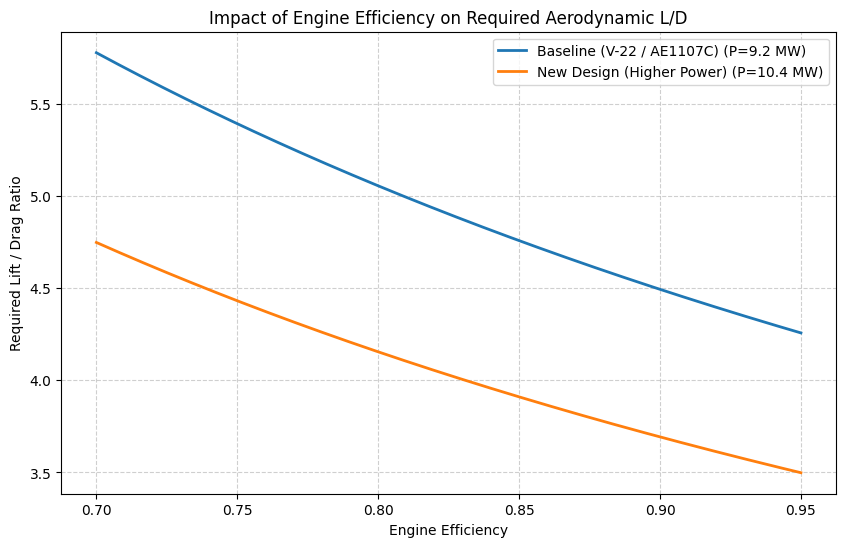

In [2]:
### Level flight, cruise: OPTIMISING FOR L/D ###
def LD_cruise(m_fuel, m_aircraft, m_payload, V, P):
    m = m_fuel + m_aircraft + m_payload
    lift = m * 9.81 # equals weight
    drag = P / V # equals thrust

    return lift/drag
    
def LD_plot(configs, eff_range):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, data in configs.items():
        m_fuel = data['fuel']
        m_ac = data['aircraft']
        m_pay = data['payload']
        V = data['speed']
        P = data['power']
        
        base_LD = LD_cruise(m_fuel, m_ac, m_pay, V, P)
        
        actual_LD = base_LD / eff_range
        
        # Plot
        ax.plot(eff_range, actual_LD, linewidth=2, label=f"{name} (P={P/1e6:.1f} MW)")

    ax.set_xlabel("Engine Efficiency")
    ax.set_ylabel("Required Lift / Drag Ratio")
    ax.set_title("Impact of Engine Efficiency on Required Aerodynamic L/D")
    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.legend(loc='best')
    
    plt.show()

def Vmax_cruise(density, wing_loading, K, Cd0):
    return np.sqrt((2/density) * wing_loading * np.sqrt(K/Cd0))

# cruise test
# parameters based on existing V-22
# these are test parameters to show the existing engine as a baseline

efficiency_factor = np.linspace(0.7, 0.95, 1000) # assumption, no data as of yet
engine_configs = {
    "Baseline (V-22 / AE1107C)": {
        "payload": 9050.0,
        "fuel": 6100.0,
        "aircraft": 27400.0 - 9050.0 - 6100.0, # derived structure mass
        "speed": 138.0, # m/s
        "power": 2*4586000.0 # 2*4.58 MW Engines, based on RR AE1107C 
    },
    "New Design (Higher Power)": { # INITIAL ASSUMPTION, TO TWEAK LATER
        "payload": 6000.0, # Same payload
        "fuel": 5800.0,    # Maybe new engine is lighter/more efficient?
        "aircraft": 12500.0, 
        "speed": 145.0,    # Target higher cruise?
        "power": 2*5200000.0 # 5.2 MW
    }
}

air_density = np.linspace(0.493, 1.225, 1000) 

LD_plot(engine_configs, efficiency_factor)

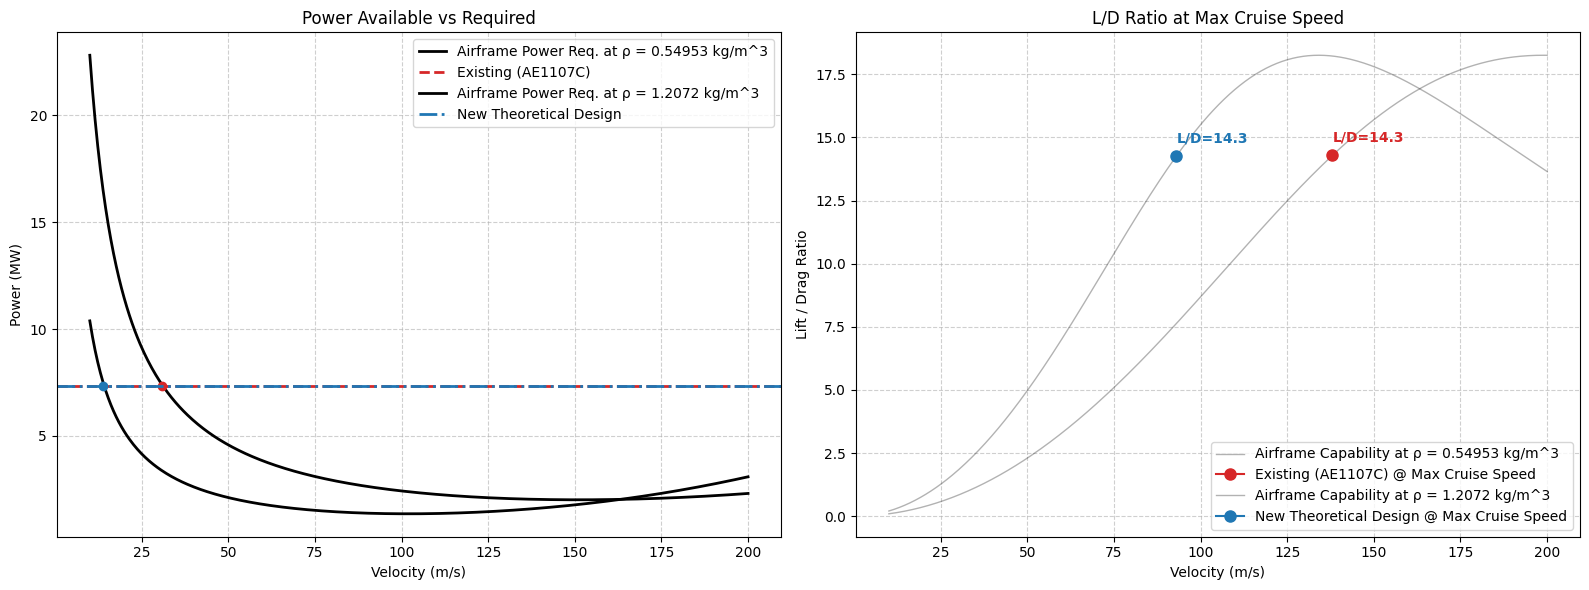

In [3]:
def get_power_required(v_range, density, weight, S, Cd0, K):
    q = 0.5 * density * v_range**2
    Cl = weight / (q * S)
    Cd = Cd0 + (K * Cl**2)
    Drag = q * S * Cd
    P_req = Drag * v_range
    
    return P_req, Drag

def compare_engines_performance(aircraft, engines, v_range):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    W = aircraft['weight']
    S = aircraft['wing_area']
    Cd0 = aircraft['Cd0']
    K = aircraft['K'] 

    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']
    styles = ['--', '-.', ':', '--']

    for i, (name, specs) in enumerate(engines.items()):

        density = specs['rho']
        
        P_req, Drag_req = get_power_required(v_range, density, W, S, Cd0, K)
        LD_ratio_curve = W / Drag_req
    
        ax1.plot(v_range, P_req/1e6, color='black', linewidth=2, label=f'Airframe Power Req. at ρ = {density} kg/m^3')
    
        ax2.plot(v_range, LD_ratio_curve, color='black', alpha=0.3, linewidth=1, label=f'Airframe Capability at ρ = {density} kg/m^3')
        
        P_shaft = specs['power']
        eff = specs['efficiency']
        P_avail = P_shaft * eff 
        c = colors[i % len(colors)]
        s = styles[i % len(styles)]
        
        ax1.axhline(y=P_avail/1e6, color=c, linestyle=s, linewidth=2, label=f'{name}')
        
        idx = np.argwhere(np.diff(np.sign(P_avail - P_req))).flatten()
        if idx.size > 0:
            p_max = v_range[idx[0]]
            #note: this essentailly identifies the speed and L/D at takeoff i.e. the point at which the power can make the aircraft airborne
            v_max = specs['cruise_speed']
            
            ax1.plot(p_max, P_avail/1e6, marker='o', color=c)
            q = 0.5 * density * v_max**2
            Cl = W / (q * S)
            Cd = Cd0 + (K * Cl**2)
            Drag_at_max = q * S * Cd
            LD_at_max = W / Drag_at_max
            
            ax2.plot(v_max, LD_at_max, marker='o', markersize=8, color=c, label=f'{name} @ Max Cruise Speed')
            
            ax2.annotate(f'L/D={LD_at_max:.1f}', 
                        (v_max, LD_at_max), 
                        xytext=(0, 10), textcoords='offset points', 
                        color=c, fontweight='bold')

    ax1.set_xlabel("Velocity (m/s)")
    ax1.set_ylabel("Power (MW)")
    ax1.set_title("Power Available vs Required")
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2.set_xlabel("Velocity (m/s)")
    ax2.set_ylabel("Lift / Drag Ratio")
    ax2.set_title("L/D Ratio at Max Cruise Speed")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

#rho = 
rho = 1.2072 #kg/m^3, assuming cruise at 500ft
v_sweep = np.linspace(10, 200, 500) 

## CD0, AND K ARE ASSUMPTIONS 
aircraft_config = {
    'weight': 21500 * 9.81, # kg -> N
    'wing_area': 35.49,      # m^2
    'Cd0': 0.015,           # Zero-lift drag coefficient (Clean config)
    'K': 0.05               # Induced drag factor
}

engine_configs = {
    "Existing (AE1107C)": {
        'power': 2*4.586e6,
        'efficiency': 0.80,
        'cruise_speed': 138, #m/s
        'rho': 0.54953 # kg/m^3, assuming cruise at 25000ft
    },
    "New Theoretical Design": {
        'power': 2*4.586e6, # same for now
        'efficiency': 0.80, # same for now
        'cruise_speed': 93, #m/s - the speed at which searches are carried out
        'rho': 1.2072 # kg/m^3, assuming cruise at 500ft
    }
}

compare_engines_performance(aircraft_config, engine_configs, v_sweep)

In [44]:
### Emergency Hover and Propeller Sizing ###
# max thrust should allow one engine to hover the aircraft such that V_y = 0
def max_thrust(mass, acc, g): # total thrust 
    return mass * g

def propeller_sizing(T_Max, density, V_e, delta_pressure): # assuming in test bed or during single engine hover
    T_prop_gross = T_Max * 0.95 # assuming 95% of thrust comes from the prop
    Area = T_prop_gross / (delta_pressure + 0.5 * density * V_e ** 2)
    return np.sqrt(4 * Area / np.pi)

def prop_max_power(T_Max, density, prop_eff, dp):
    return np.sqrt((2 * (T_Max ** 3)) / (np.pi * density * prop_eff**2 * dp**2))
    
max_weight = 19000 #kg
gravity = 9.81 #m/s^2
downwards_acc = 0.5
acc = np.linspace(0.1, 5, 500)
height = 1500 #m, roughly 5k ft
air_density = 1.05 #  np.linspace(1.05, 1.225, 100) # range between sea level to 1500 m

# takeoff_kinematics(acc, height)
thrust_maximum = max_thrust(max_weight, downwards_acc, gravity)
prop_diameter = propeller_sizing(thrust_maximum, air_density, 20, 1500)
P = prop_max_power(thrust_maximum, air_density, 0.80, prop_diameter)

print(f"T_max = {thrust_maximum}, D_p = {prop_diameter}, P = {P}")

T_max = 186390.0, D_p = 11.48233229171348, P = 6821175.547382889


In [78]:
def ISA_atmosphere(altitude):
    g = 9.81 # m/s^2
    R = 8.314 # J/(mol K)
    M = 0.02896 # kg/mol
    P0 = 101325.0 # Pa
    T0 = 288.15 # K
    L = 0.0065 # K/m, temperature gradient w.r.t alt

    altitude = np.asarray(altitude)
    T = T0 - (L * altitude)
    P = P0 * (1 - (L * altitude) / T0) ** (g * M / (R * L))
    rho = (P * M) / (R * T)
    
    return P, T, rho

def isentropic_calc(p_in, T_in, pressure_ratio, gamma, turbo):
    if turbo == "comp":
        return p_in * pressure_ratio, T_in * pressure_ratio ** ((gamma-1) / gamma)
    elif turbo == "turb":
        return p_in / pressure_ratio, T_in / (pressure_ratio ** ((gamma-1) / gamma))

def enthalpy_calc(Cp, T_high, T_low):
    return abs(Cp * (T_high - T_low))

def compressor(p1, T1, pressure_ratio, gamma, Cp):
    p2, T2 = isentropic_calc(p1, T1, pressure_ratio, gamma, "comp")
    work = 0.85 * enthalpy_calc(Cp, T2, T1)
    return work, p2, T2

def combustor(target_T3, T2, P2, pressure_loss, Cp):
    heat = enthalpy_calc(Cp, target_T3, T2)
    return heat, P2 * pressure_loss

def turbine(p3, target_T3, pressure_ratio, gamma, Cp):
    p4, T4 = isentropic_calc(p3, target_T3, pressure_ratio, gamma, "turb")
    work = 0.89 * enthalpy_calc(Cp, target_T3, T4)
    return work, p4, T4

def brayton_cycle_analysis(alt_list, tit_list, pr_list):
    gamma_c, Cp_c = 1.4, 1.005
    gamma_h, Cp_h = 1.33, 1.15
    combustor_eff = 0.95
    results = []

    for altitude, T3, pressure_ratio in product(alt_list, tit_list, pr_list):
        P1, T1, rho1 = ISA_atmosphere(altitude)
        work_comp, P2, T2 = compressor(P1, T1, pressure_ratio, gamma_c, Cp_c)
        heat_in, P3 = combustor(T3, T2, P2, combustor_eff, Cp_h)
        expansion_ratio = P3 / P1
        work_turb, P4, T4 = turbine(P3, T3, expansion_ratio, gamma_h, Cp_h)

        work_net = work_turb - work_comp
        sfc = (heat_in / work_net) * 3.6e6 / 43.1e6

        results.append({
            "Cruise_Altitude": altitude,
            "TIT (K)": T3,
            "PR": pressure_ratio,
            "Availabe Specific Propeller Power (kJ / kg)": work_net,
            "Heat In (kJ / kg)": heat_in,
            "SFC (kg / kWh)": sfc,
            "Inlet Air Density (kg/m^3)": rho1
        })
        
    return pd.DataFrame(results)

def performance_plot(df, design_altitude):
    subset = df[df['Cruise_Altitude'] == design_altitude].copy()
    plt.style.use('bmh')
    fig = plt.figure(figsize=(18, 12))
    plt.suptitle(f"Engine Cycle Performance @ {design_altitude}m Altitude", fontsize=16)

    # Pressure Ratio vs. SFC
    ax1 = fig.add_subplot(2, 2, 1)
    scatter1 = ax1.scatter(
        subset['PR'], 
        subset['SFC (kg / kWh)'], 
        c=subset['TIT (K)'], 
        cmap='inferno', 
        s=50, 
        edgecolor='k'
    )
    ax1.set_xlabel("Pressure Ratio")
    ax1.set_ylabel("SFC (kg/kWh)")
    ax1.set_title("Pressure Ratio and Turbine Inlet Temperature Effects on SFC")
    fig.colorbar(scatter1, ax=ax1, label='TIT (K)')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Design Space Heatmap (TIT vs PR)
    ax2 = fig.add_subplot(2, 2, 2)
    pivot_table = subset.pivot_table(values='SFC (kg / kWh)', index='TIT (K)', columns='PR')
    contour = ax2.contourf(
        pivot_table.columns, 
        pivot_table.index, 
        pivot_table.values, 
        levels=20, 
        cmap='RdYlGn_r'
    )
    ax2.set_xlabel("Pressure Ratio")
    ax2.set_ylabel("Turbine Inlet Temp (K)")
    ax2.set_title("Iso-SFC Contours (Green is Better)")
    fig.colorbar(contour, ax=ax2, label='SFC (kg/kWh)')


    # (Specific Power vs. SFC)
    ax3 = fig.add_subplot(2, 1, 2)
    tits = sorted(subset['TIT (K)'].unique())
    for t in tits:
        line_data = subset[subset['TIT (K)'] == t]
        ax3.plot(line_data['Availabe Specific Propeller Power (kJ / kg)'], 
                line_data['SFC (kg / kWh)'], 
                color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax3.text(line_data['Availabe Specific Propeller Power (kJ / kg)'].iloc[-1], 
                line_data['SFC (kg / kWh)'].iloc[-1], 
                f'TIT={t}K', fontsize=9)

    prs = sorted(subset['PR'].unique())
    for p in prs:
        if p % 2 == 0: 
            line_data = subset[subset['PR'] == p]
            ax3.plot(line_data['Availabe Specific Propeller Power (kJ / kg)'], 
                    line_data['SFC (kg / kWh)'], 
                    color='blue', linestyle='--', linewidth=0.8, alpha=0.5)
    scatter3 = ax3.scatter(
        subset['Availabe Specific Propeller Power (kJ / kg)'], 
        subset['SFC (kg / kWh)'], 
        c=subset['TIT (K)'], 
        cmap='inferno', 
        s=60, 
        zorder=3
    )

    ax3.set_xlabel("Specific Power (kW / kg/s)")
    ax3.set_ylabel("SFC (kg/kWh)")
    ax3.set_title("Specific Power vs SFC")
    ax3.invert_yaxis() 
    fig.colorbar(scatter3, ax=ax3, label='TIT (K)')

    plt.tight_layout()
    plt.show()

def prop_sizing(required_shaft_power, cycle_data, density, v_face):
    sp_power = cycle_data['Available Specific Propeller Power (kJ / kg)']
    mdot_req = required_shaft_power / sp_power
    area = mdot_req / (density * v_face)
    diameter = 2 * np.sqrt(area / np.pi)
    
    return mdot_req, diameter

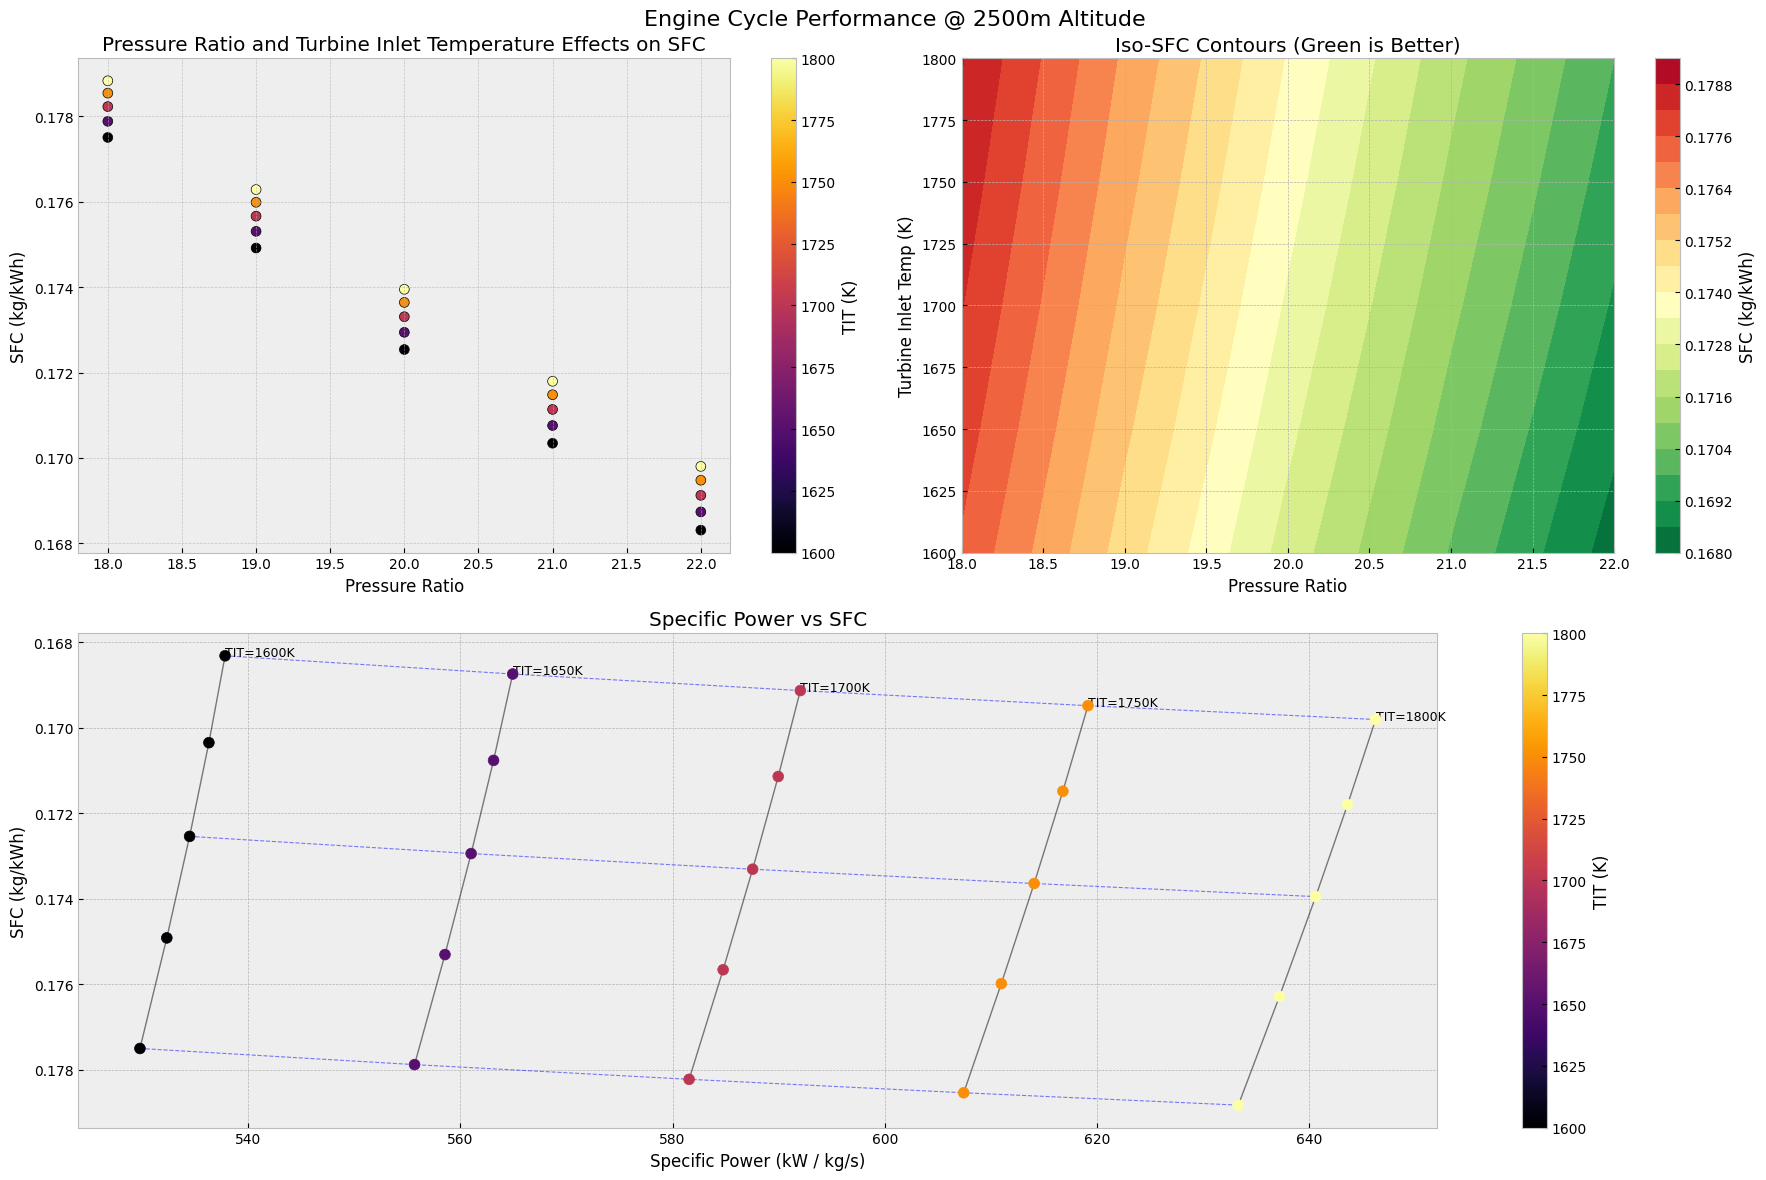

,Cruise_Altitude,TIT (K),PR,Availabe Specific Propeller Power (kJ / kg),Heat In (kJ / kg),SFC (kg / kWh),Inlet Air Density (kg/m^3),Required Air Massflow (kg/s)
0,150,1600,18,513.059364,1085.787446,0.176768,1.207314,13.295100
1,150,1600,19,515.126122,1074.046082,0.174154,1.207314,13.241758
2,150,1600,20,516.828449,1062.738196,0.171753,1.207314,13.198143
3,150,1600,21,518.214074,1051.827258,0.169535,1.207314,13.162853
4,150,1600,22,519.322921,1041.281383,0.167477,1.207314,13.134748
5,150,1650,18,538.934017,1143.287446,0.177192,1.207314,12.656792
6,150,1650,19,541.337916,1131.546082,0.174594,1.207314,12.600587
7,150,1650,20,543.355935,1120.238196,0.172207,1.207314,12.553789
8,150,1650,21,545.038139,1109.327258,0.170004,1.207314,12.515043
9,150,1650,22,546.426443,1098.781383,0.167960,1.207314,12.483246


In [91]:
alt_list = np.arange(150, 2550, 50)
temp_list = np.arange(1600, 1850, 50)
pressure_ratio_list = np.arange(18, 23, 1)

df = brayton_cycle_analysis(alt_list, temp_list, pressure_ratio_list)
performance_plot(df, alt_list[-1])

df["Required Air Massflow (kg/s)"] = P / (1000 * df['Availabe Specific Propeller Power (kJ / kg)'])
mask = (df["Required Air Massflow (kg/s)"] >= 11.5) & (df["Required Air Massflow (kg/s)"] <= 13.0)
df = df[(df['Cruise_Altitude'] == 150)]
df

In [8]:
### Horizontal Takeoff ###

In [9]:
### Search ###
# high air density, low V

In [10]:
### Hover ###
# high  air density, V = 0